# LLM Inference Pipeline

This notebook implements the LLM inference pipeline described in `pipeline_spec.md`.

Sections:
- Setup & installs
- Parse and validate spec
- Tokenizer & Model loader
- Prompt construction
- Dataset loading & sampling
- Batched inference & streaming generator
- Extraction, metrics, and plotting
- Demo runs and simple tests


In [1]:
# Setup: Install dependencies and import packages

# If running in binder or a fresh environment you may need to install packages.
# Use `%pip install` to ensure installs are available in the notebook kernel.

# Uncomment and run if you need to install packages
# %pip install -q transformers accelerate torch pandas matplotlib seaborn datasets evaluate tqdm regex sentencepiece

import os
import json
import re
from dataclasses import dataclass, asdict
from typing import List, Optional, Dict, Any, Tuple
import logging
import random
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Try importing transformers and torch and give friendly guidance if missing
try:
    import torch
    from transformers import (
        AutoTokenizer,
        AutoModelForCausalLM,
        pipeline,
        logging as hf_logging,
    )
except Exception as e:
    raise RuntimeError(
        "Transformers or Torch not available in the kernel. Please run the install cell: `%pip install transformers torch`"
    ) from e

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
hf_logging.set_verbosity_error()

# Device detection
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.mps.is_available() else "cpu"
)
logger.info(f"Using device: {DEVICE}")

# Reproducible seeds
DEFAULT_SEED = 42
random.seed(DEFAULT_SEED)
torch.manual_seed(DEFAULT_SEED)

# Default paths / constants
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "datasets"
PIPELINE_SPEC = PROJECT_ROOT / "pipeline_spec.md"
DEFAULT_MODEL = (
    "Qwen/Qwen2.5-0.5B-Instruct"  # per spec; we will fallback if unavailable
)

INFO:root:Using device: mps


In [2]:
@dataclass
class PipelineSpec:
    default_model: str = DEFAULT_MODEL
    tokenizer_context_length: int = 2048
    classification_system_prompt: str = (
        "You are a news trustworthiness classifier.\n"
        "Your task is to classify news articles as either trustworthy or untrustworthy.\n"
        "Your answer should consist of exactly one token: 0 if the article is untrustworthy and 1 if it is trustworthy.\n\n"
    )
    user_template: str = "ARTICLE: {article}"


pipeline_spec = PipelineSpec()

Parsed pipeline spec: PipelineSpec(default_model='Qwen/Qwen2.5-0.5B-Instruct', tokenizer_context_length=2048, classification_system_prompt='You are a news trustworthiness classifier.\nYour task is to classify news articles as either trustworthy or untrustworthy.\nYour answer should consist of exactly one token: 0 if the article is untrustworthy and 1 if it is trustworthy.\n\n', user_template='ARTICLE: {article}')


In [3]:
# Cache util
class SimpleCache:
    def __init__(self):
        self._cache = {}

    def get(self, key):
        return self._cache.get(key)

    def set(self, key, value):
        self._cache[key] = value


cache = SimpleCache()

In [4]:
# # Tokenizer setup and verification


# def load_tokenizer(model_name: str, max_length: Optional[int] = None):
#     try:
#         tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
#         if tokenizer.pad_token is None:
#             # Ensure pad token exists for batching
#             tokenizer.add_special_tokens({"pad_token": "<|pad|>"})
#         if max_length is not None:
#             tokenizer.model_max_length = max_length
#         logger.info(
#             f"Loaded tokenizer for: {model_name} with max_length={tokenizer.model_max_length}"
#         )
#         return tokenizer
#     except Exception as e:
#         logger.warning(f"Failed to load tokenizer for {model_name}: {e}")
#         raise


# # Round-trip test helper
# def tokenizer_round_trip_test(tokenizer):
#     txt = "This is a short test sentence."
#     encoded = tokenizer(txt)
#     decoded = tokenizer.decode(encoded.input_ids)
#     assert isinstance(decoded, str)
#     assert txt == decoded
#     logger.info("Tokenizer round-trip test passed.")


# # Example default tokenizer load (with safe fallback)
# try:
#     default_tokenizer = load_tokenizer(
#         pipeline_spec.default_model, max_length=pipeline_spec.tokenizer_context_length
#     )
# except Exception:
#     logger.info("Falling back to 'gpt2' tokenizer for demo purposes.")
#     default_tokenizer = load_tokenizer("gpt2", max_length=1024)

# # run simple test
# tokenizer_round_trip_test(default_tokenizer)

INFO:root:Loaded tokenizer for: Qwen/Qwen2.5-0.5B-Instruct with max_length=2048
INFO:root:Tokenizer round-trip test passed.


In [22]:
# Model loader: device placement, caching, and smoke tests


def load_model(
    model_name: str, device: str = DEVICE, dtype: Optional[torch.dtype] = None
):
    """Load a causal LM model with graceful fallback.

    Returns: (model, tokenizer)
    """
    # Check cache
    cache_key = f"model::{model_name}::device::{device}"
    cached_model = cache.get(cache_key)
    if cached_model is not None:
        logger.info(f"Using cached model for {model_name}")
        return cached_model

    try:
        model = AutoModelForCausalLM.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        # Add pad token if missing
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({"pad_token": "<|pad|>"})
            model.resize_token_embeddings(len(tokenizer))
        model.to(device)
        model.eval()
        cache.set(cache_key, (model, tokenizer))
        logger.info(f"Loaded model {model_name} to {device}")
        return model, tokenizer
    except Exception as e:
        logger.warning(f"Failed to load model {model_name}: {e}")
        raise


model, tokenizer = load_model(pipeline_spec.default_model)

INFO:root:Using cached model for Qwen/Qwen2.5-0.5B-Instruct


In [86]:
# Prompt templates and preprocessing

SYSTEM_PROMPT = pipeline_spec.classification_system_prompt
USER_TEMPLATE = pipeline_spec.user_template


def make_prompts(
    articles: list[str] | pd.Series,
    system: str = SYSTEM_PROMPT,
    user_template: str = USER_TEMPLATE,
    prefilled=False,
) -> list[list[dict[str, str]]]:
    """
    Given a batch of articles (a list), returns a batch of formatted prompts.
    Each prompt is a list of dicts.
    Each dict contains role and content information.
    The system prompt contains generic classification instructions.
    The user content contains the article to be classified.
    Optionally, we prefill the model response to guide classification output.
    """
    # check that the articles are of the right type
    if type(articles) is not list and type(articles) is not pd.Series:
        raise ValueError(
            f"`articles` needs to be a list of strings. Got {type(articles)} instead."
        )

    messages_batch = []
    for article in articles:
        user_text = user_template.format(article=article)
        messages = [
            {"role": "system", "content": system},
            {"role": "user", "content": user_text},
        ]
        if prefilled:
            messages.append(
                {"role": "assitant", "content": "CLASSIFICATION (0 or 1):"},
            )
        messages_batch.append(messages)
    return messages_batch


def encode_prompts(prompts: list[list[dict[str, str]]], tokenizer):
    """
    Given a batch of formatted prompts, returns a batch of tokenized prompts.
    """
    prompts = [
        tokenizer.apply_chat_template(p, tokenize=False, add_generation_prompt=True)
        for p in prompts
    ]
    return tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=pipeline_spec.tokenizer_context_length,
    )


def display_prompt(prompts: list[dict]) -> None:
    """
    Given a batch of (untokenized) prompts, pretty prints the first one.
    """
    for line in prompts[0]:
        for k, v in line.items():
            print(f"[{k}]: {v}")


# Example
prompts = ["This is a prompt."]
display_prompt(make_prompts(prompts, prefilled=True))

[role]: system
[content]: You are a news trustworthiness classifier.
Your task is to classify news articles as either trustworthy or untrustworthy.
Your answer should consist of exactly one token: 0 if the article is untrustworthy and 1 if it is trustworthy.


[role]: user
[content]: ARTICLE: This is a prompt.
[role]: assitant
[content]: CLASSIFICATION (0 or 1):


In [87]:
# Dataset loader, sampling, and a small demo dataset


def load_dataset(
    data_dir: Path = DATA_DIR, max_rows: Optional[int] = None, use_seed=True
) -> pd.DataFrame:
    """
    Load dataset by combining `fake.csv` (label 0) and `true.csv` (label 1).
    Returns dataframe with columns "article" and "label".
    """
    fake_path = data_dir / "fake.csv"
    true_path = data_dir / "true.csv"

    if fake_path.exists() and true_path.exists():
        try:
            fake = pd.read_csv(fake_path)
            true = pd.read_csv(true_path)

            # Try to find an `article` column; fallback to first column
            def get_text_col(df):
                for c in ["article", "text", "content"]:
                    if c in df.columns:
                        return df[c].astype(str)
                return df.iloc[:, 0].astype(str)

            fake_text = get_text_col(fake)
            true_text = get_text_col(true)
            fake_df = pd.DataFrame({"article": fake_text, "label": 0})
            true_df = pd.DataFrame({"article": true_text, "label": 1})
            df = pd.concat([fake_df, true_df], ignore_index=True)
            if max_rows is not None:
                df = df.sample(
                    n=min(len(df), max_rows),
                    random_state=(DEFAULT_SEED if use_seed else None),
                )
            return df
        except Exception as e:
            logger.warning(f"Failed to read CSVs: {e}")

    # Fallback synthetic dataset
    logger.info("Using synthetic demo dataset (small).")
    demo = [
        (
            "Government releases new public health guidelines that are consistent with prior research and expert consensus.",
            1,
        ),
        (
            "Aliens landed on the White House lawn last night, multiple sources confirm",
            0,
        ),
        (
            "Scientific team publishes peer-reviewed article showing new vaccine efficacy.",
            1,
        ),
        (
            "Miracle cure for diabetes discovered in backyard herb; no clinical trials yet",
            0,
        ),
    ]
    df = pd.DataFrame(demo, columns=["article", "label"])
    if max_rows:
        df = df.head(max_rows)
    return df


def sample_k(
    df: pd.DataFrame, k: int, mode: str = "random", seed: Optional[int] = None
) -> pd.DataFrame:
    if seed is None:
        seed = DEFAULT_SEED
    if mode == "random":
        return df.sample(n=min(k, len(df)), random_state=seed).reset_index(drop=True)
    elif mode == "first":
        return df.head(k).reset_index(drop=True)
    else:
        raise ValueError("mode must be 'random' or 'first'")


# Quick demo load
dataset = load_dataset(max_rows=200)
dataset.head()

,article,label
22216,"21st Century Wire says Ben Stein, reputable pr...",0
27917,WASHINGTON (Reuters) - U.S. President Donald T...,1
25007,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
1377,"On Monday, Donald Trump once again embarrassed...",0
32476,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1


### Test tokenizer on prompts

In [88]:
messages = make_prompts(dataset["article"].iloc[:3], prefilled=True)
prompts = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
try:
    tok_ids = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=pipeline_spec.tokenizer_context_length,
    )
    logger.info("Successfully tokenized prompt")
except Exception as e:
    logger.warning("Failed to tokenize prompt")
messages

INFO:root:Successfully tokenized prompt


[[{'role': 'system',
   'content': 'You are a news trustworthiness classifier.\nYour task is to classify news articles as either trustworthy or untrustworthy.\nYour answer should consist of exactly one token: 0 if the article is untrustworthy and 1 if it is trustworthy.\n\n'},
  {'role': 'user',
   'content': 'ARTICLE: 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trump s Executive Order on travel. Stein referred to the judgement by the 9th Circuit Court in Washington state as a  Coup d tat against the executive branch and against the constitution.  Stein went on to call the Judges in Seattle  political puppets  and the judiciary  political pawns. Watch the interview below for the complete statements and note the stark contrast to

# Generate Predictions

In [100]:
# Batched synchronous generation and streaming demo


def generate_batch(
    model,
    tokenizer,
    prompts: list[list[dict[str, str]]],
    max_new_tokens: int = 32,
    temperature: float = 0.0,
    do_sample: bool = False,
    batch_size: int = 4,
) -> List[str]:
    outputs = []
    model_device = next(model.parameters()).device
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i : i + batch_size]
        batch_prompts = tokenizer.apply_chat_template(
            batch_prompts,
            tokenize=False,
            add_generation_prompt=True,
        )
        enc = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        # move tensors to device
        input_ids = enc.input_ids.to(model_device)
        attention_mask = enc.attention_mask.to(model_device)

        # generate
        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=do_sample,
                temperature=temperature,
                pad_token_id=tokenizer.pad_token_id,
            )
        # For each generated sequence, decode only the generated portion
        for ids, prompt in zip(generated_ids, batch_prompts):
            text = tokenizer.decode(ids, skip_special_tokens=True)
            prompt_ids = tokenizer.apply_chat_template(
                prompt, tokenize=True, add_generation_prompt=True
            )
            response_ids = ids[len(prompt_ids) :]
            text = tokenizer.decode(response_ids, skip_special_tokens=True)
            outputs.append(text)
    return outputs


# Extract classification labels


def extract_classification(text: str) -> Optional[int]:
    if not isinstance(text, str):
        return None
    # Try to find an explicit 0/1 token
    m = re.search(r"\b([01])\b", text)
    if m:
        return int(m.group(1))
    # Try to find words
    txt = text.lower()
    if "untrust" in txt or "fake" in txt or "not" in txt and "trust" in txt:
        return 0
    if "trust" in txt or "true" in txt or "reliable" in txt:
        return 1
    return None


# Demo of extraction
tests = ["0", "1", "The answer is 0.", "Trustworthy", "This seems fake."]
for t in tests:
    print(t, "->", extract_classification(t))

0 -> 0
1 -> 1
The answer is 0. -> 0
Trustworthy -> 1
This seems fake. -> 0


### Test generation

In [101]:
articles = dataset["article"].iloc[:3]
messages = make_prompts(articles)
processed_messages = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
enc = tokenizer(
    processed_messages,
    return_tensors="pt",
    padding=True,
    truncation=True,
)
prompts = make_prompts(articles)
prompts[0]
generate_batch(
    model,
    tokenizer,
    prompts,
)

['trustworthy.\nYour answer should consist of exactly one token: 0 if the article is untrustworthy and 1 if it is trustworthy.\n\n\nuser\nARTICLE: 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trump s Executive Order on travel. Stein referred to the judgement by the 9th Circuit Court in Washington state as a  Coup d tat against the executive branch and against the constitution.  Stein went on to call the Judges in Seattle  political puppets  and the judiciary  political pawns. Watch the interview below for the complete statements and note the stark contrast to the rhetoric of the leftist media and pundits who neglect to note that no court has ever blocked any Presidential orders in immigration in the past or discuss the legal effi

Accuracy: 0.75


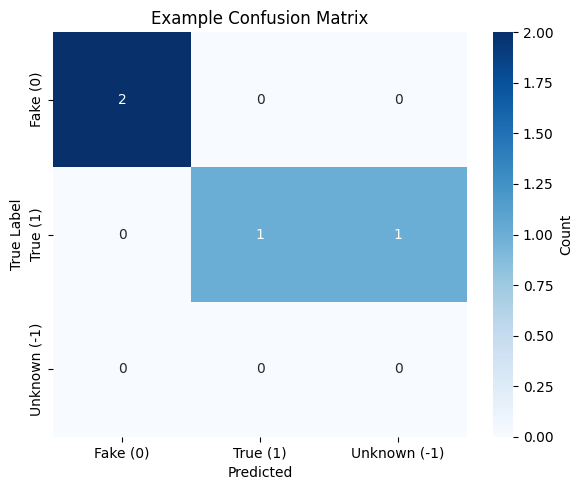

In [105]:
# Metrics and plotting

from sklearn.metrics import accuracy_score, confusion_matrix


def compute_metrics(y_true: List[int], y_pred: List[Optional[int]]) -> Dict[str, Any]:
    # Convert None to a special class or treat as incorrect
    y_pred_clean = [(p if p is not None else -1) for p in y_pred]
    # For accuracy, treat None as incorrect
    valid_mask = [p in (0, 1) for p in y_pred]
    acc = accuracy_score(y_true, [p if p in (0, 1) else -1 for p in y_pred_clean])
    cm = confusion_matrix(
        y_true, [p if p in (0, 1) else 2 for p in y_pred_clean], labels=[0, 1, 2]
    )
    return {"accuracy": acc, "confusion_matrix": cm}


def plot_confusion_matrix(cm, title: str = "Confusion Matrix"):
    """Display confusion matrix as a seaborn heatmap."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Fake (0)", "True (1)", "Unknown (-1)"],
        yticklabels=["Fake (0)", "True (1)", "Unknown (-1)"],
        cbar_kws={"label": "Count"},
    )
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()


def plot_metric_comparison(metrics_by_model: Dict[str, Dict[str, Any]]):
    df = pd.DataFrame(
        [
            {"model": m, "accuracy": metrics["accuracy"]}
            for m, metrics in metrics_by_model.items()
        ]
    )
    sns.barplot(data=df, x="model", y="accuracy")
    plt.ylim(0, 1)
    plt.title("Model accuracy comparison")


# Example usage with dummy preds
metrics = compute_metrics([1, 0, 1, 0], [1, 0, None, 0])
print(f"Accuracy: {metrics['accuracy']}")
plot_confusion_matrix(metrics["confusion_matrix"], "Example Confusion Matrix")

INFO:root:Using cached model for Qwen/Qwen2.5-0.5B-Instruct


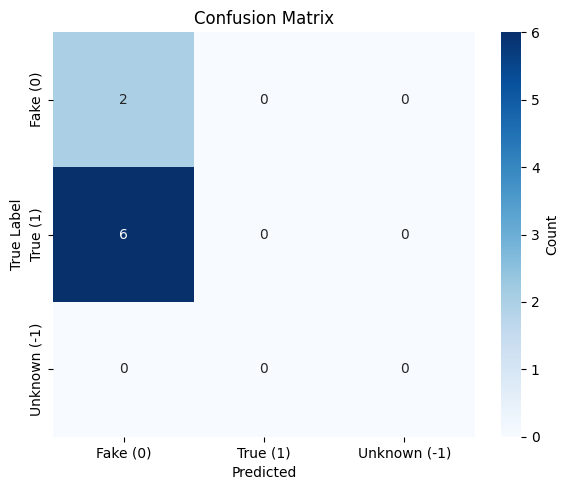

In [ ]:
# Full pipeline runner for a model name (small, non-optimized demo)


def run_pipeline_on_dataset(
    model_name: str,
    df: pd.DataFrame,
    k: int = 20,
    sample_mode: str = "random",
    seed: Optional[int] = None,
):
    model, tokenizer = load_model(model_name)
    samples = sample_k(df, k=k, mode=sample_mode, seed=seed)
    prompts = make_prompts(samples.article.tolist())
    outputs = generate_batch(model, tokenizer, prompts, batch_size=4)
    preds = [extract_classification(o) for o in outputs]
    metrics = compute_metrics(samples.label.tolist(), preds)
    return {"model": model_name, "metrics": metrics, "preds": preds, "samples": samples}


demo_res = run_pipeline_on_dataset(pipeline_spec.default_model, dataset, k=8)
plot_confusion_matrix(demo_res["metrics"]["confusion_matrix"])

In [109]:
model_list = [
    "Qwen/Qwen2.5-0.5B-Instruct",
]
NUM_SAMPLES = 10
SAMPLE_MODE = "random"
results = []
for model in model_list:
    results.append(
        run_pipeline_on_dataset(model, dataset, k=NUM_SAMPLES, sample_mode=SAMPLE_MODE)
    )

INFO:root:Using cached model for Qwen/Qwen2.5-0.5B-Instruct


In [112]:
def compare_model_results(results: Dict[str, Dict[str, Any]]) -> None:
    """
    Compare accuracies across multiple model runs.

    Args:
        results: Dictionary mapping model names to results from run_pipeline_on_dataset.
                 Each result should have a 'metrics' key containing 'accuracy'.
    """
    # Extract accuracies
    comparison_data = []
    for model_name, result in results.items():
        accuracy = result["metrics"]["accuracy"]
        comparison_data.append({"model": model_name, "accuracy": accuracy})

    df = pd.DataFrame(comparison_data)

    # Create plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="model", y="accuracy", palette="Set2")
    plt.ylim(0, 1)
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nAccuracy Summary:")
    print(df.to_string(index=False))
    print(
        f"\nBest model: {df.loc[df['accuracy'].idxmax(), 'model']} ({df['accuracy'].max():.4f})"
    )


# Example usage (uncomment to test):
results = {
    "model_1": run_pipeline_on_dataset(
        model_name="microsoft/Phi-3-mini-4k-instruct", df=dataset, k=3
    ),
    "model_2": run_pipeline_on_dataset(
        model_name="Qwen/Qwen2.5-0.5B-Instruct", df=dataset, k=3
    ),
}
compare_model_results(results)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 20.11 GiB, other allocations: 3.47 MiB, max allowed: 20.13 GiB). Tried to allocate 108.00 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).